In [136]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

!pip install yfinance

import requests, io
import pandas as pd

url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
s = requests.get(url).content


In [137]:
companies = pd.read_csv(io.StringIO(s.decode('utf-8')))
companies.head()

,Symbol,Company Name,Security Name,Market Category,Test Issue,Financial Status,Round Lot Size
0,AAIT,iShares MSCI All Country Asia Information Tech...,iShares MSCI All Country Asia Information Tech...,G,N,N,100.0
1,AAL,"American Airlines Group, Inc.","American Airlines Group, Inc. - Common Stock",Q,N,N,100.0
2,AAME,Atlantic American Corporation,Atlantic American Corporation - Common Stock,G,N,N,100.0
3,AAOI,"Applied Optoelectronics, Inc.","Applied Optoelectronics, Inc. - Common Stock",G,N,N,100.0
4,AAON,"AAON, Inc.","AAON, Inc. - Common Stock",Q,N,N,100.0


Lookup Ticker symbol based on serach term:

In [198]:
search = 'Emerging'

for i in companies['Security Name'].tolist():
  if search in i: print(f"{i} Symbol: {companies[i == companies['Security Name']].Symbol.tolist()[0]}")

BLDRS Emerging Markets 50 ADR Index Fund Symbol: ADRE
WisdomTree Emerging Markets Dividend Growth Fund Symbol: DGRE
iShares MSCI Emerging Markets Asia Index Fund Symbol: EEMA
iShares MSCI Emerging Markets EMEA Index Fund Symbol: EEME
iShares MSCI Emerging Markets Latin America Index Fund Symbol: EEML
iShares MSCI Emerging Markets Growth Index Fund Symbol: EGRW
WisdomTree Emerging Markets Corporate Bond Fund Symbol: EMCB
WisdomTree Emerging Markets Consumer Growth Fund Symbol: EMCG
iShares MSCI Emerging Markets Consumer Discrectionary Sector Index Fund Symbol: EMDI
iShares MSCI Emerging Markets Energy Sector Capped Index Fund Symbol: EMEY
iShares S&P Emerging Markets Infrastructure Index Fund Symbol: EMIF
iShares MSCI Emerging Markets Value Index Fund Symbol: EVAL
First Trust Emerging Markets Local Currency Bond ETF Symbol: FEMB
Vanguard Emerging Markets Government Bond ETF Symbol: VWOB


## Data loading
https://finance.yahoo.com/

[*********************100%***********************]  1 of 1 completed
(2457, 6)


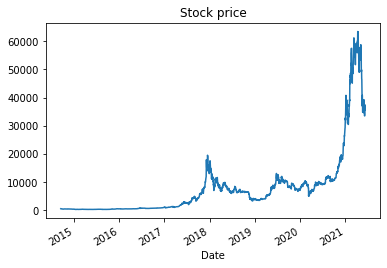

In [215]:
import pandas as pd
import yfinance as yf
#from yahoofinancials import YahooFinancials

#tsla_df = yf.download('TSLA', 
#                      start='2019-01-01', 
#                      #end='2021-06-12', 
#                      progress=False)

yahoo_df = yf.download('BTC-USD')

print(yahoo_df.shape)
#yahoo_df.head()

#ticker = yf.Ticker('TSLA')               # alternative to yf.download()
#tsla_df = ticker.history(period="max")
yahoo_df['Close'].plot(title="Stock price")

In [216]:
training_set = yahoo_df['Close'].values.reshape(-1,1)

Create (X, y) pair for LSTM:

In [217]:
def sliding_windows(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]       # vector:  data_{i : i+tau}   'input/features'
        _y = data[i+seq_length]           # scalar : data_{i+tau+1}     'target'
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

In [218]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [219]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout = 0):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout = dropout)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        return out

## Training

In [220]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, 0.)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):

    outputs = lstm(trainX)   # make forward pass
    optimizer.zero_grad()    # set gradient to zero
    
    # obtain the loss function
    loss = criterion(outputs, trainY)   # evaluate MSE
    
    loss.backward()   # compute gradient
    optimizer.step()   # make SGD parameter update

    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.00600
Epoch: 100, loss: 0.00004
Epoch: 200, loss: 0.00004
Epoch: 300, loss: 0.00003
Epoch: 400, loss: 0.00003
Epoch: 500, loss: 0.00003
Epoch: 600, loss: 0.00003
Epoch: 700, loss: 0.00003
Epoch: 800, loss: 0.00003
Epoch: 900, loss: 0.00003
Epoch: 1000, loss: 0.00003
Epoch: 1100, loss: 0.00003
Epoch: 1200, loss: 0.00002
Epoch: 1300, loss: 0.00002
Epoch: 1400, loss: 0.00002
Epoch: 1500, loss: 0.00002
Epoch: 1600, loss: 0.00002
Epoch: 1700, loss: 0.00002
Epoch: 1800, loss: 0.00002
Epoch: 1900, loss: 0.00002


## Plot predictions

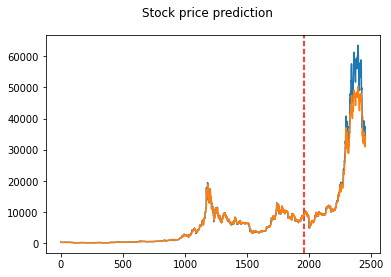

In [221]:
lstm.eval()
train_predict = lstm(dataX)     # forward pass the whole data set

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()      # corresponding ground truth

data_predict = sc.inverse_transform(data_predict)   # revert to original scale
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Stock price prediction')
plt.show()